## Train classifier by layers

This notebook trains a classifier that operates in two layers:
- First we use a SVM classifier to label utterances with high degree of certainty.
- Afterwards we use heuristics to complete the labeling

### Import and path definition

In [2]:
import os
import pandas as pd
import numpy as np
import random
import pickle
import sys
import matplotlib.pyplot as plt

root_path = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
sys.path.append(root_path)

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from src import phase_classification as pc

data_path = os.path.join(root_path,'data')
tables_path = os.path.join(data_path,'tables')

### Load data

In [3]:
WITH_STEMMING = True
#REMOVE_STOPWORDS = True
SEED = 10
NUM_TOPICS = 60
random.seed(SEED)
CLASS_W = False

In [4]:
file_name = '[train]IBL_topic_distribution_by_utterance_with_phrase_before_and_after_time_utterance_minimum_0_words_with_stemming_{}_{}.xlsx'.format(WITH_STEMMING,NUM_TOPICS)
df_data = pd.read_excel(os.path.join(tables_path,'train',file_name))

In [5]:
df_data.head()

,Topic before 1,Topic before 2,Topic before 3,Topic before 4,Topic before 5,Topic before 6,Topic before 7,Topic before 8,Topic before 9,Topic before 10,...,Topic after 60,phase,phase_1,phase_2,phase_3,phase_4,phase_5,utterance,length utterance,utterance_relative_time
0,0.028715,0.012903,0.006044,0.005848,0.005266,0.057161,0.007285,0.004799,0.006815,0.008096,...,0.005848,1,1,0,0,0,0,SATUNNAINEN,0.000000,0.000000
1,0.028715,0.012903,0.006044,0.005848,0.005266,0.057161,0.007285,0.004799,0.006815,0.008096,...,0.005848,1,1,0,0,0,0,siel QUESTION_SYMBOL onks oo palo,0.065574,0.010417
2,0.025757,0.010554,0.004944,0.004783,0.004307,0.107424,0.005959,0.003926,0.005574,0.006622,...,0.005215,1,1,0,0,0,0,no tää varm muutu,0.049180,0.017361
3,0.023489,0.010554,0.004944,0.004783,0.004307,0.054591,0.005959,0.003926,0.005574,0.006622,...,0.003782,1,1,0,0,0,0,aja T_ ATOMI ehtiny törm ton ver,0.098361,0.020833
4,0.021241,0.009412,0.004409,0.004266,0.003841,0.045906,0.059203,0.003501,0.004971,0.005906,...,0.007721,1,1,0,0,0,0,ton ver ai pitä muute kato sil taas oo lask to...,0.213115,0.027778


### split data

In [6]:
the_keys = list(set(df_data['phase']))
total_samples = 0
class_samples = {}
for key in the_keys:
    n = list(df_data.phase.values).count(key)
    #print("key {}, total {}".format(key,n))
    total_samples += n
    class_samples[key] = n
print(total_samples)
for key in the_keys:
    print("key {}, samples: {}, prop: {}".format(key,class_samples[key],round(class_samples[key]*1.0/total_samples,2)))

1600
key 1, samples: 403, prop: 0.25
key 2, samples: 175, prop: 0.11
key 3, samples: 406, prop: 0.25
key 4, samples: 62, prop: 0.04
key 5, samples: 554, prop: 0.35


In [7]:
filter_rows = list(range(180))+[187,188]
row_label = 180

In [8]:
dfs_train,dfs_val = pc.split_df_discussions(df_data,.2,SEED)
X_train,y_train = pc.get_joined_data_from_df(dfs_train,filter_rows,row_label)
X_val,y_val = pc.get_joined_data_from_df(dfs_val,filter_rows,row_label)
len(X_train)

1328

In [9]:
dfs_all,_ = pc.split_df_discussions(df_data,.0,SEED)
X_all,y_all = pc.get_joined_data_from_df(dfs_all,filter_rows,row_label)

In [10]:
len(X_train[0])

182

### Classify first layer

In [11]:
class_weight = {}
for key in the_keys:
    class_weight[key] = 1000.0/class_samples[key]

In [12]:
if CLASS_W:
    svc = SVC(kernel='linear',random_state=SEED,max_iter=3000,probability=True,class_weight="balanced")#,class_weight=class_weight)
else:
    svc = SVC(kernel='linear',random_state=SEED,max_iter=3000,probability=True,class_weight=None)
svc.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svc.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svc.score(X_val, y_val)))

Accuracy of SVM classifier on training set: 0.51
Accuracy of SVM classifier on test set: 0.57


In [13]:
pred = svc.predict(X_val)
labels = ["Phase {}".format(i) for i in range(1,6)]
df = pd.DataFrame(confusion_matrix(y_val, pred),columns=["Predicted {}".format(i) for i in labels])
df.index = labels
#print(" ")
print(classification_report(y_val, pred))
df

              precision    recall  f1-score   support

           1       0.72      0.61      0.66       101
           2       0.00      0.00      0.00         9
           3       0.86      0.10      0.17        63
           4       0.00      0.00      0.00         3
           5       0.49      0.91      0.63        96

   micro avg       0.57      0.57      0.57       272
   macro avg       0.41      0.32      0.29       272
weighted avg       0.64      0.57      0.51       272



C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\teacher_topic_model\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Predicted Phase 1,Predicted Phase 2,Predicted Phase 3,Predicted Phase 4,Predicted Phase 5
Phase 1,62,0,1,0,38
Phase 2,0,0,0,0,9
Phase 3,15,0,6,0,42
Phase 4,0,0,0,0,3
Phase 5,9,0,0,0,87


### Find threshold

In [20]:
np.arange(0,1,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

Look for the distance to the second max

In [14]:
pred_val = svc.predict_proba(X_val)
prob_pred = [v[int(y_val[i]-1)] for i,v in enumerate(pred_val)]

(array([26., 30., 33., 36., 26., 40., 36., 30.,  8.,  7.]),
 array([0.0313363 , 0.11093981, 0.19054333, 0.27014684, 0.34975035,
        0.42935386, 0.50895737, 0.58856089, 0.6681644 , 0.74776791,
        0.82737142]),
 <a list of 10 Patch objects>)

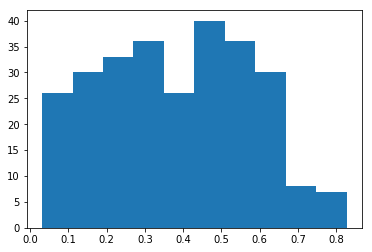

In [15]:
plt.hist(prob_pred)

In [16]:
tuple_winner_pred = [(np.max(v),prob_pred[i],np.max(v)==prob_pred[i]) for i,v in enumerate(pred_val)]
values_ok = [v[0] for i,v in enumerate(tuple_winner_pred) if v[2]==True]
values_not_ok = [v[0] for i,v in enumerate(tuple_winner_pred) if v[2]==False]
values_dist_not_ok = [v[0]-v[1] for i,v in enumerate(tuple_winner_pred) if v[2]==False]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 4., 1., 4.,
        4., 1., 4., 5., 3., 2., 2., 2., 9., 6., 7., 6., 3., 5., 2., 4., 6.,
        5., 6., 3., 6., 4., 3., 6., 5., 3., 4., 6., 3., 0., 1., 2., 1., 1.,
        1., 1., 0., 2., 0., 1., 3., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 array([0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ,
        0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41,
        0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52,
        0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63,
        0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74,
        0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85,
        0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94]),
 <a list of 74 Patch objects>)

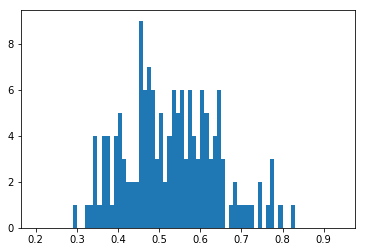

In [17]:
plt.hist(values_ok,np.arange(0.2,.95,.01))

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,
         2.,  5.,  1.,  4.,  5.,  7.,  4.,  0., 10.,  3.,  7.,  4.,  5.,
         2.,  1.,  4.,  2.,  3.,  1.,  8.,  3.,  2.,  2.,  4.,  3.,  6.,
         1.,  2.,  1.,  2.,  1.,  0.,  0.,  4.,  0.,  3.,  1.,  1.,  0.,
         0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ,
        0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41,
        0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52,
        0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63,
        0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74,
        0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85,
        0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94]),
 <a list of 74 Patch objects>)

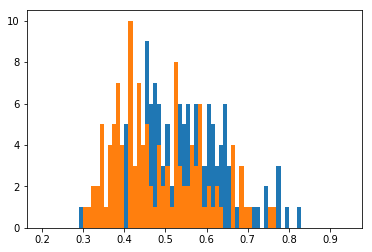

In [18]:
plt.hist(values_ok,np.arange(0.2,.95,.01))
plt.hist(values_not_ok,np.arange(0.2,.95,.01))

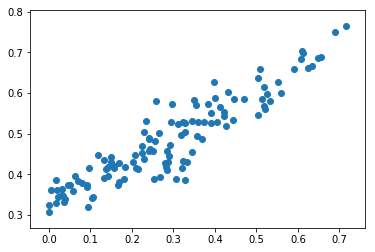

In [19]:
plt.scatter(values_dist_not_ok,values_not_ok)

Define Threshold 

In [64]:
t = 0.55

In [65]:
output_first_layer = pc.first_layer_classifier(X_all,t,svc)
comparison = list(zip(output_first_layer,y_all))

In [66]:
df_data['first_layer'] = output_first_layer

### Second layer

In [67]:
pred_val = svc.predict_proba([X_all[3]])
pred_val

array([[0.66066022, 0.06912646, 0.05550903, 0.0021581 , 0.2125462 ]])

In [68]:
second_layer = pc.second_layer_classifier_max_border(X_all,df_data,svc)

In [69]:
df_data['second_layer'] = second_layer
df_data.to_excel(os.path.join(tables_path,'[second_layer]'+file_name))

In [70]:
"Number of not predicted {}".format(second_layer.count(-1))

'Number of not predicted 0'

In [71]:
second_aux = []
y_all_aux = []
for i,e in enumerate(second_layer):
    if e!=-1:
        second_aux.append(second_layer[i])
        y_all_aux.append(y_all[i])
df = pd.DataFrame(confusion_matrix(y_all_aux, second_aux),columns=["Predicted {}".format(i) for i in labels])
df.index = labels
print(classification_report(y_all_aux, second_aux))
df

              precision    recall  f1-score   support

           1       0.56      0.59      0.57       403
           2       0.65      0.23      0.34       175
           3       0.60      0.50      0.55       406
           4       0.75      0.05      0.09        62
           5       0.51      0.71      0.60       554

   micro avg       0.55      0.55      0.55      1600
   macro avg       0.61      0.42      0.43      1600
weighted avg       0.57      0.55      0.53      1600



,Predicted Phase 1,Predicted Phase 2,Predicted Phase 3,Predicted Phase 4,Predicted Phase 5
Phase 1,236,6,39,0,122
Phase 2,45,41,22,0,67
Phase 3,67,2,204,0,133
Phase 4,0,2,6,3,51
Phase 5,77,12,69,1,395


In [72]:
with open(os.path.join(data_path,'classifier_svm_before_after_best_of_two_cw_{}.pickle'.format(CLASS_W)),'wb') as f:
    pickle.dump(svc,f)

In [73]:
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svc.score(X_all, y_all_aux)))

Accuracy of SVM classifier on training set: 0.51


In [74]:
CLASS_W

False